# Exploring tools for comparative metagenomics

by Georg Zeller, EMBL Heidelberg, Germany, 2017 (zeller@embl.de)

Here we're going to explore some tools for comparing metagenomes. They are generic in the sense that they should work for both amplicon (16S rRNA gene, 18S, ITS amplicons) and shotgun sequencing data. We will focus on taxonomic comparisons, but most techniques are also applicable to functional data (gene families or domains, KEGG, GO annotations etc.), but summarization at pathway level may pose some additional analysis challenges not discussed here.

In [1]:
# some technicalities to get started
set.seed(2017) # to make steps depending on random numbers reproducible

# resize plots in Jupyter Notebook to more convenient dimensions
options(repr.plot.width = 4, repr.plot.height = 4)

# we are going to use functions from the following packages
library('vegan')
library('FastKNN')
library('coin')
library('RColorBrewer')

# to install them, use the following commands from within a Jupyter notebook
#install.packages('vegan',        repos='http://cran.us.r-project.org')
#install.packages('FastKNN',      repos='http://cran.us.r-project.org')
#install.packages('coin',         repos='http://cran.us.r-project.org')
#install.packages('RColorBrewer', repos='http://cran.us.r-project.org')


Loading required package: permute
Loading required package: lattice
This is vegan 2.4-4
Loading required package: survival


### Loading taxonomic abundance profiles

We assume to be given a table of read counts which contains one taxon per row and one sample per column (instead of taxa you might have gene families, domains pathways etc.)

In [2]:
# this is data published with H.B. Nielsen et al., Nat. Biotechnol. 2014
#fn.tax.profile <- 'http://www.bork.embl.de/~zeller/public_metagenomics_data/ES-UC-N100_tax-ab-specI.tsv'
#fn.metadata <- 'http://www.bork.embl.de/~zeller/public_metagenomics_data/ES-UC-N100_metadata.tsv'
#fn.tax.profile <- 'http://www.bork.embl.de/~zeller/public_metagenomics_data/ES-CD-N71_tax-ab-specI.tsv'
#fn.metadata <- 'http://www.bork.embl.de/~zeller/public_metagenomics_data/ES-CD-N71_metadata.tsv'

# this is data from G. Zeller et al., Mol. Syst. Biol. 2014
fn.tax.profile <- 'http://www.bork.embl.de/~zeller/public_metagenomics_data/FR-CRC-N141_tax-ab-specI.tsv'
fn.metadata <- 'http://www.bork.embl.de/~zeller/public_metagenomics_data/FR-CRC-N141_metadata.tsv'

# this is data from Feng et al., Gut 2015
#fn.tax.profile <- 'http://www.bork.embl.de/~zeller/public_metagenomics_data/CN-CRC-N128_tax-ab-specI.tsv'
#fn.metadata <- 'http://www.bork.embl.de/~zeller/public_metagenomics_data/CN-CRC-N128_metadata.tsv'

# read abundance matrix
ab <- read.table(fn.tax.profile, quote = '', sep = '\t', header = TRUE, row.names = 1,
                 check.names = FALSE)
ab <- as.matrix(ab)

# read additonal patient metadata
meta <- read.table(fn.metadata, quote = '', sep = '\t', header = TRUE, row.names = 1, 
                   check.names = FALSE, stringsAsFactors = FALSE)

# assert correspondence between abundance and meta data
stopifnot(all(rownames(meta) == colnames(ab)))
cat('Loaded data: n =', ncol(ab), 'samples, p =', nrow(ab), 'taxa (species).\n')

# for the following we will assume two groups as in a standard case-control study
GROUPS <- unique(meta$Group)
#print(GROUPS)
stopifnot(length(GROUPS) == 2)

# resort according to groups
o <- order(meta$Group)
meta <- meta[o,]
ab <- ab[,o]

Loaded data: n = 141 samples, p = 1754 taxa (species).


### Data preprocessing

For some comparisons later on data transformations such as conversion to relative abundances (also called total sum scaling) or rarefying helps to minimize technical differences due to differences in sequencing library size. More information on the effect of these transformations can be found in [McMurdie and Holmes, 2014](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003531), [Weiss et al., 2017](https://microbiomejournal.biomedcentral.com/articles/10.1186/s40168-017-0237-y) and [Costea et al., 2014](http://www.nature.com/nmeth/journal/v11/n4/full/nmeth.2897.html).

9 samples have < 50000 reads.



CRC CTR 
 49  83 

Retained 772 abundance features, 772 relative abundance features and 472 rarefied abundance features.


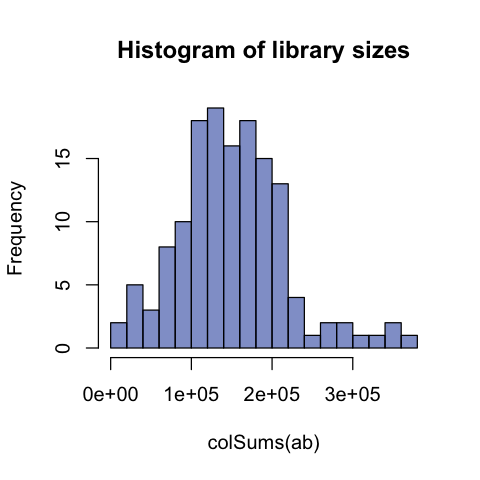

In [3]:
# library sizes
hist(colSums(ab), 20, col = '#0030A080', main = 'Histogram of library sizes')

# remove outlier samples with very few reads
min.lib.size <- 50000
cat(sum(colSums(floor(ab)) < min.lib.size), 'samples have <', min.lib.size, 'reads.\n')
meta <- meta[colSums(floor(ab)) >= min.lib.size,]
ab <- ab[,colSums(floor(ab)) >= min.lib.size]
table(meta$Group)


# relative abundances
rel.ab <- prop.table(ab, 2)
# rarefied abundances
rar.ab <- t(rrarefy(t(floor(ab)), min.lib.size))
# need matrix transpose to match vegan's conventions about count matrix

# remove taxa whose abundance is zero across all samples
ab <- ab[rowSums(ab) > 0,]
rel.ab <- rel.ab[rowSums(rel.ab) > 0,]
rar.ab <- rar.ab[rowSums(rar.ab) > 0,]
cat('Retained', nrow(ab), 'abundance features,', 
                nrow(rel.ab), 'relative abundance features and', 
                nrow(rar.ab), 'rarefied abundance features.\n')

## Community dissimilarity analysis

In addition to commonly used distances (such as the Euclidean or L1/Manhattan distances), many dissimilarity measures have been proposed by ecologists to compare to habitat samples for differences in observed species content. The R vegan packages offers a large selection.

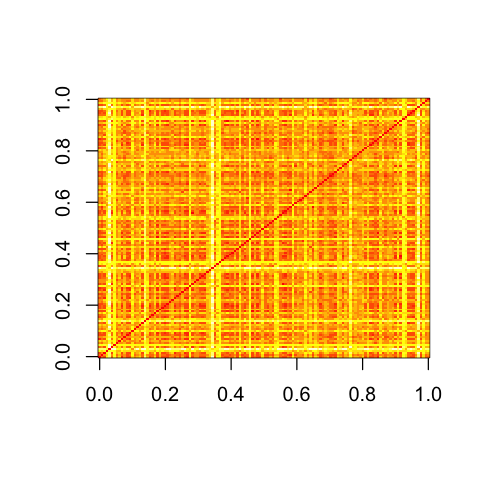

In [4]:
# calculate pairwise dissimilarities using the vegan package
diss.bray <- vegdist(t(rar.ab), method = 'bray') # transpose to match vegan's conventions
diss.manhattan <- vegdist(t(rel.ab), method = 'manhattan')
diss.euclid <- vegdist(t(rel.ab), method = 'euclidean')
diss.logeuclid <- vegdist(t(log10(rel.ab + 1E-6)), method = 'euclidean')
diss.canberra <- vegdist(t(rar.ab), method = 'canberra')
diss.jaccard <- vegdist(t(rar.ab>0), method = 'jaccard')


diss.list <- list(braycurtis   = as.matrix(diss.bray), 
                  manhattan    = as.matrix(diss.manhattan), 
                  euclidean    = as.matrix(diss.euclid),
                  logeuclidean = as.matrix(diss.logeuclid),
                  canberra     = as.matrix(diss.canberra),
                  jaccard      = as.matrix(diss.jaccard))


image(as.matrix(diss.list[[1]]))


### Visualization of a pairwise dissimilarity matrix by ordination

Principal component analysis (PCA) is a commonly used exploratory data analysis tool that is very powerful at revealing structure in a data set. It "rotates" a high-dimensional data set into a coordinate system (orthogonal basis) of linearly uncorrelated principal components (by an orthogonal transformation) in such a way that the first principal component accounts for most of the variance; the second coordinate, orthogonal to the first one, for most of the remaining variance and so on. For the purpose of visual data exploration, one often plots a projection to the first two (or three) principal components - which, intuitively speaking, carry most of the information contained in a high-dimensional data set.

Principal coordinate analysis (PCoA, also called multidemnsional scaling, MDS) can be seen as a more general ordination technique which aims to place samples in a lower dimensional space such that _arbitrary, pre-specified_ distances between samples are preserved as well as possible; these distances can be provided by the user as an input to PCoA.


PCo 1       PCo 2      
CCIS17669415ST-4-0  0.12874346  0.01777583
CCIS48725289ST-4-0  0.07194394  0.05805924
CCIS06260551ST-3-0  0.19816312 -0.09638611
CCIS40244499ST-3-0 -0.17963442 -0.10921833
CCIS85214191ST-3-0 -0.42578320 -0.29707685
CCIS87167916ST-4-0  0.21971601 -0.11880219

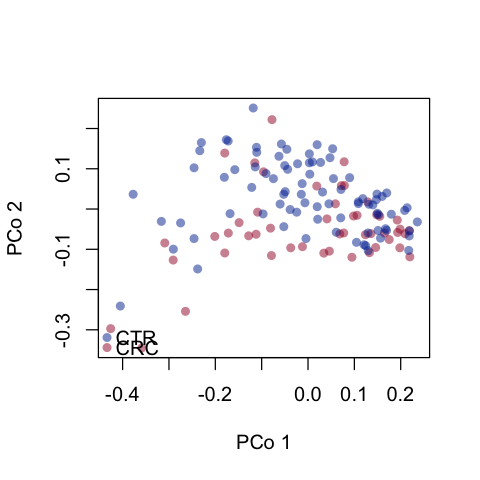

In [5]:
# compute PCoA
pcoa.proj <- cmdscale(diss.list[[1]], k = 2)
colnames(pcoa.proj) <- c('PCo 1', 'PCo 2')

head(pcoa.proj)

# visualize
plot(pcoa.proj, pch = 16, col = ifelse(meta$Group==GROUPS[1], '#0030A080', '#A0003080'))
legend('bottomleft', GROUPS, pch = 16, col = c('#0030A080', '#A0003080'), bty='n')

### Investigating separation between groups

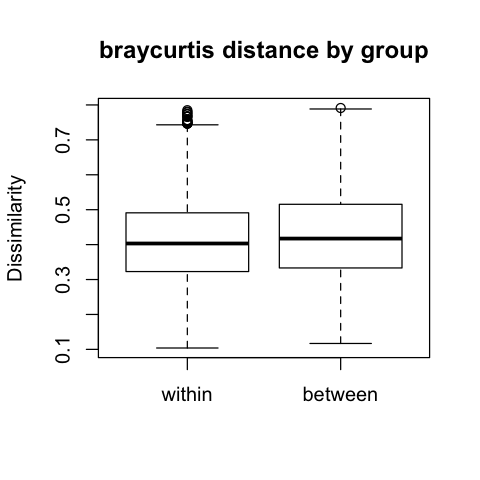

In [6]:
within.idx <- matrix(FALSE, ncol(ab), ncol(ab))
between.idx <- matrix(FALSE, ncol(ab), ncol(ab))
for (i in 1:(ncol(ab)-1)) {
    for (j in (i+1):ncol(ab)) {
        if (meta$Group[i] == meta$Group[j]) {
            within.idx[i,j] <- TRUE
        } else {
            between.idx[i,j] <- TRUE   
        }
    }
}
#image(within.idx)
#image(between.idx)

boxplot(diss.list[[1]][within.idx], diss.list[[1]][between.idx],
        main = paste(names(diss.list)[1], 'distance by group'), 
        names = c('within', 'between'), ylab='Dissimilarity')


### Assessing separation using k-nearest neighbor classification

To quantify whether samples from the same group cluster together, we can assess how often neighboring samples agree with respect to their group membership. This is the concept underlying the simple, yet powerful, k-nearest neighbor classifier implemented below.

In [7]:
# k-nearest neighbor classifier
k <- 5

# matrix of nearest neighbors for each sample
nn <- matrix(0, nrow = ncol(ab), k)
rownames(nn) <- colnames(ab)
# agreement between group of neighbors and group of actual sample
nn.agreement <- rep(NA, ncol(ab))
names(nn.agreement) <- colnames(ab)
for (i in 1:ncol(ab)) {
    nn[i,] <- as.numeric(k.nearest.neighbors(i, diss.list[[1]], k = k))
    nn.agreement[i] <- mean(meta$Group[nn[i,]] == meta$Group[i])
}

# Accuracy of kNN classifier
cat('k-NN accuracy ', names(diss.list)[1], ': ', mean(nn.agreement > 0.5), '\n', sep='')

k-NN accuracy braycurtis: 0.7045455


##### Caveat
Although as a researcher you hope to see larger dissimilarities between groups than within, it is not always possible to observe such a clear clustering of microbial abundance data. Even in cases where global dissimilarity does not reveal differences in community composition, individual taxa may show significant abundance changes between groups as seen in the following.

## Testing individual features for association with groups

To test individual taxa (or functional microbiome features) for association with external factors such as disease, I recommend using a nonparametric approach. To assess the differences between two groups, we can use the Wilcoxon test (also called Mann-Whitney U test); for more than two groups the Kruskal-Wallis test. To correct for multiple hypthesis testing, we will employ false discovery rate controls [Benjamini & Hochberg, 1995](https://www.jstor.org/stable/2346101), [Storey & Tibshirani, 2003](http://www.pnas.org/content/100/16/9440).

A comparison of testing approaches can be found in [Weiss et al., 2017](https://microbiomejournal.biomedcentral.com/articles/10.1186/s40168-017-0237-y). LefSe offers neat visualizations of differentially abundant taxa identified by Wilcoxon tests [Segata et al., 2011](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2011-12-6-r60).

In [8]:
# we will only test taxa which reach an abundance of 1E-3 in at least on sample
ab.cutoff <- 1E-3
filt.rel.ab <- rel.ab[apply(rel.ab, 1, max) >= ab.cutoff,]

# we are going to test each taxon separately
p.values <- rep(1, nrow(filt.rel.ab))
for (t in 1:nrow(filt.rel.ab)) {
        p.values[t] <- wilcox.test(filt.rel.ab[t, meta$Group == GROUPS[1]], 
                                   filt.rel.ab[t, meta$Group == GROUPS[2]])$p.value
}
# afterwards we need to adjust for multiple hypothesis testing using the FDR
p.values <- p.adjust(p.values, method = 'fdr')

sign.idx <- which(p.values < 0.05)
sign.idx <- sign.idx[order(p.values[sign.idx])]
for (i in sign.idx)
    cat(rownames(filt.rel.ab)[i], ': ', format(p.values[i]), '\n', sep='')

unclassified Fusobacterium [Cluster1482]: 3.551226e-07
unclassified Fusobacterium [Cluster1481]: 3.293916e-05
Porphyromonas asaccharolytica [Cluster1056]: 0.0002856816
Pseudoflavonifractor capillosus [Cluster1579]: 0.0006877612
unnamed Ruminococcaceae bacterium D16 [Cluster1580]: 0.003370338
Prevotella nigrescens [Cluster1069]: 0.007688445
Peptostreptococcus stomatis [Cluster1530]: 0.007688445
Eubacterium ventriosum [Cluster1629]: 0.007688445
Eubacterium rectale [Cluster1630]: 0.007688445
Eubacterium hallii [Cluster1597]: 0.01028025
unnamed Ruminococcus sp. SR1/5 [Cluster1621]: 0.02022863
unnamed Parvimonas sp. oral taxon 110 [Cluster1506]: 0.02319619
Eubacterium eligens [Cluster1627]: 0.02319619
butyrate-producing bacterium [Cluster1595]: 0.02358068
unnamed Ruminococcus sp. 5_1_39BFAA [Cluster1620]: 0.02885566
Roseburia intestinalis [Cluster1631]: 0.02885566
unnamed Parvimonas sp. oral taxon 393 [Cluster1507]: 0.02941851
Clostridium symbiosum [Cluster1600]: 0.03778172
Clostridium hyle

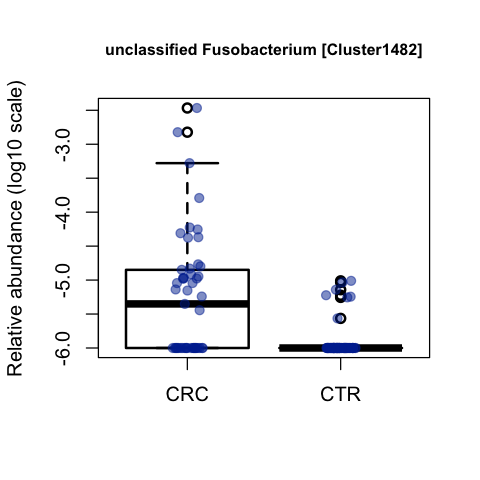

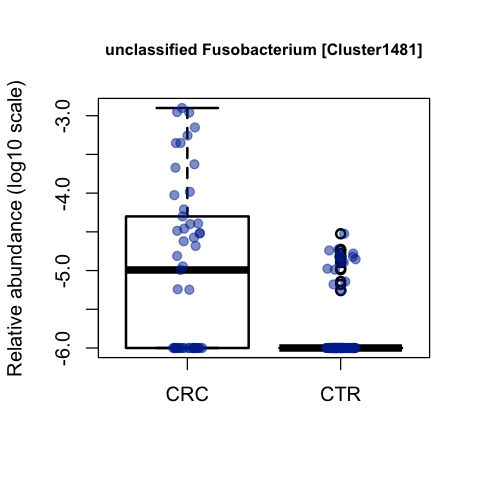

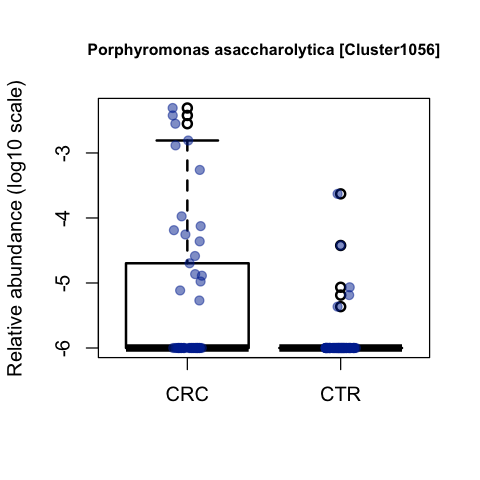

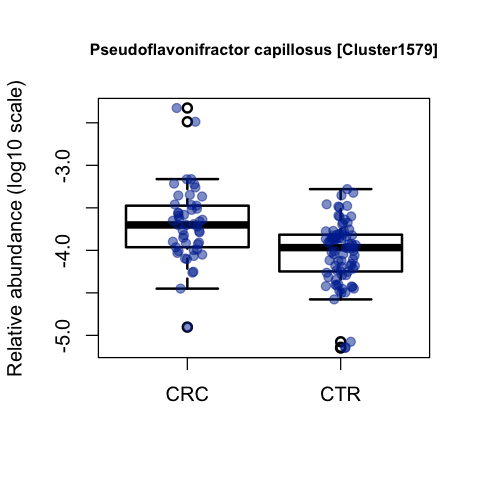

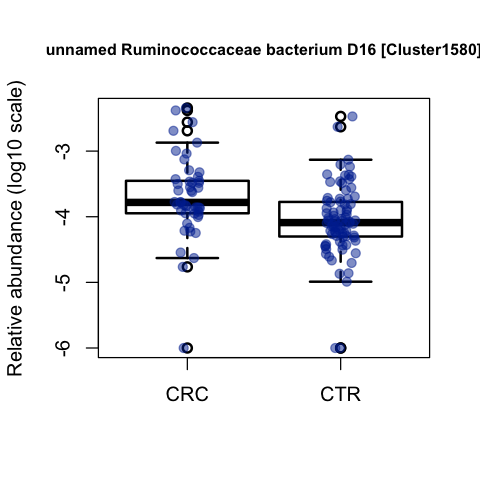

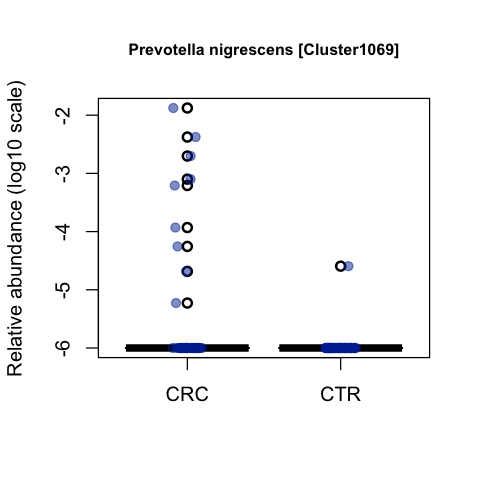

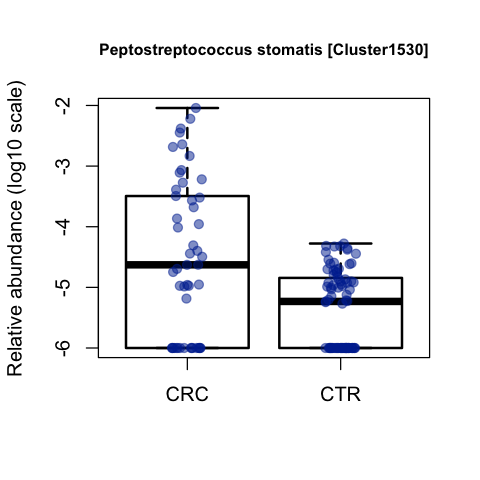

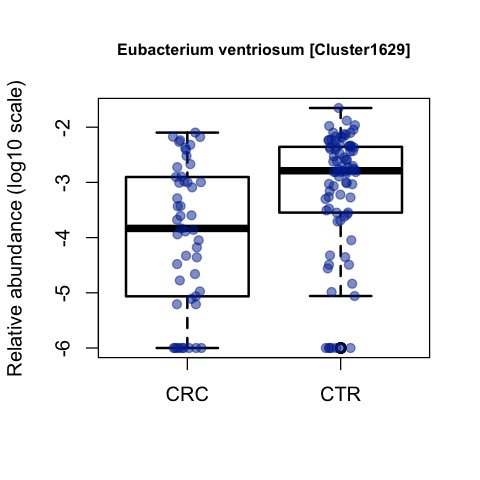

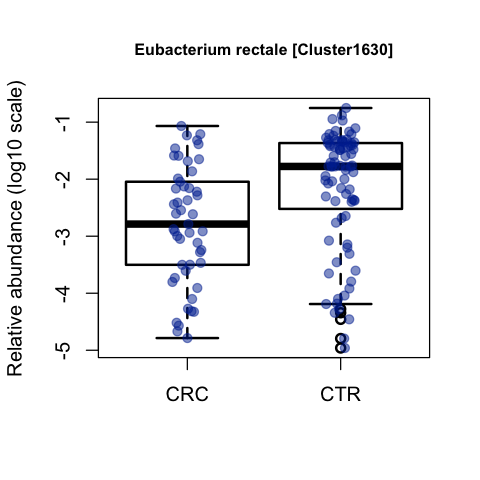

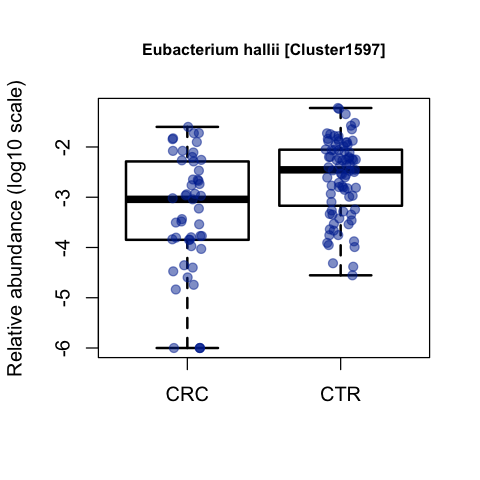

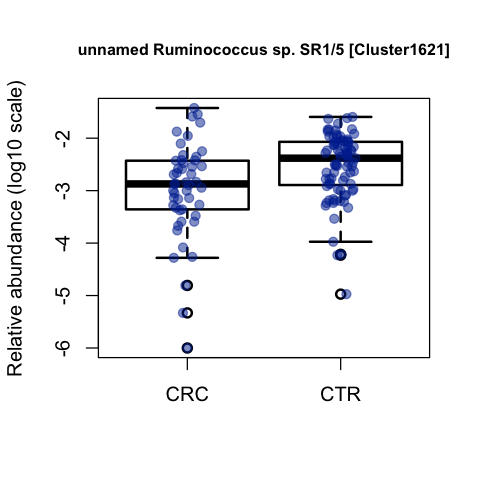

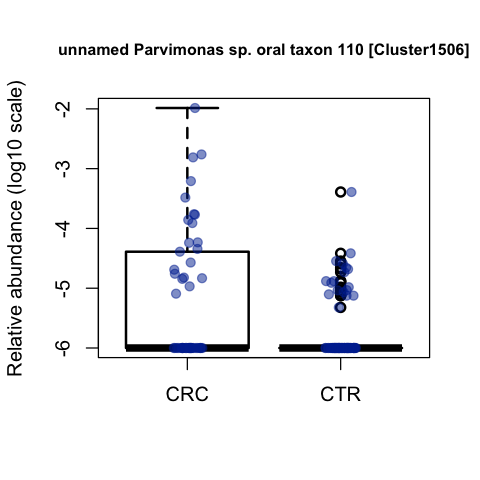

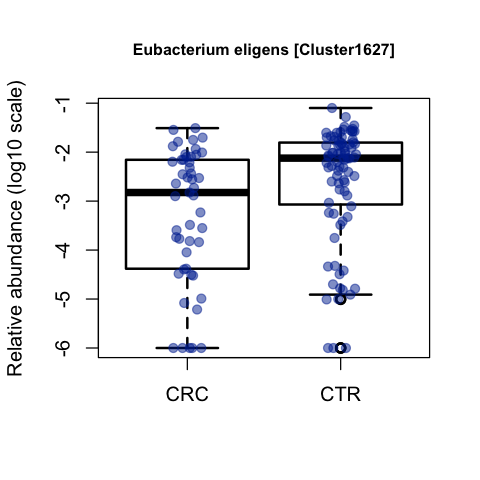

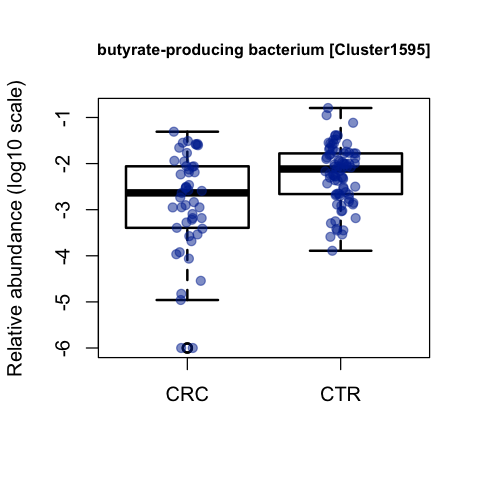

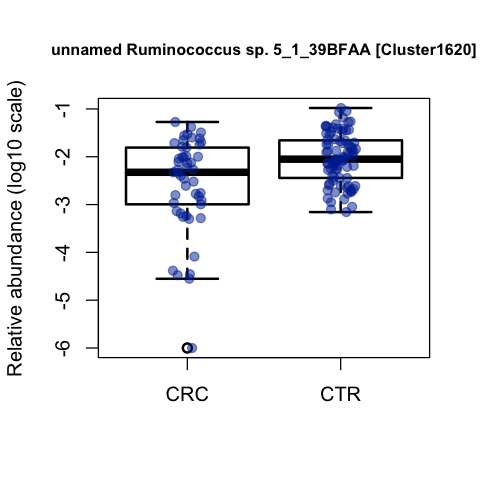

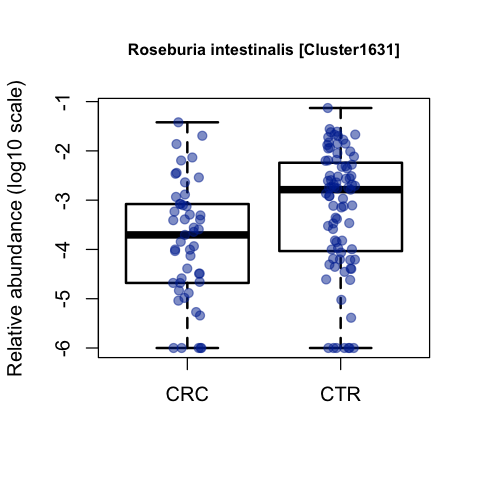

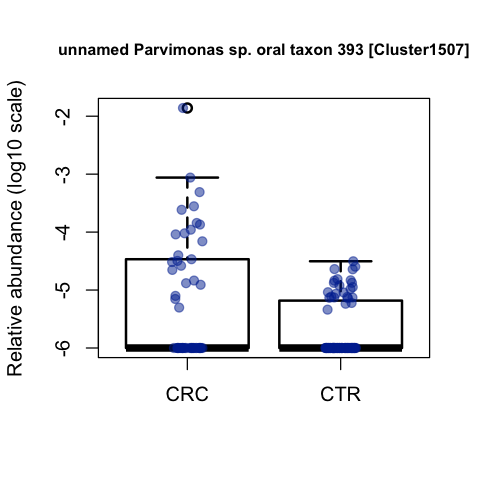

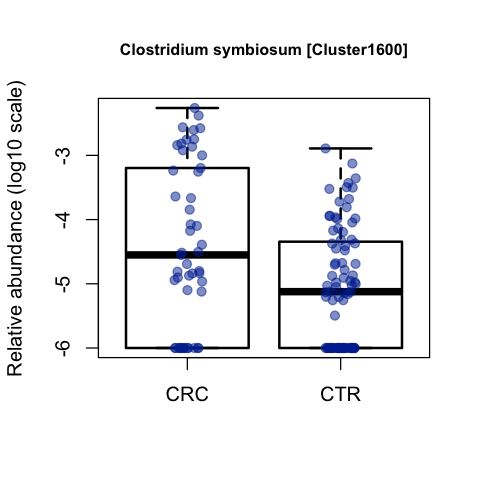

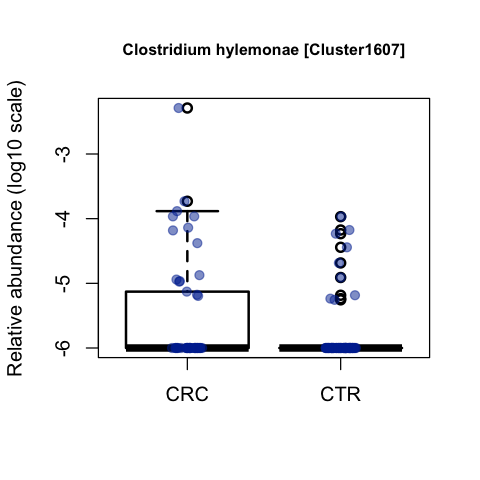

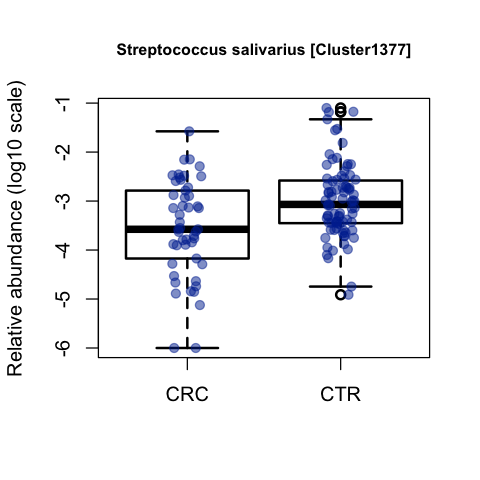

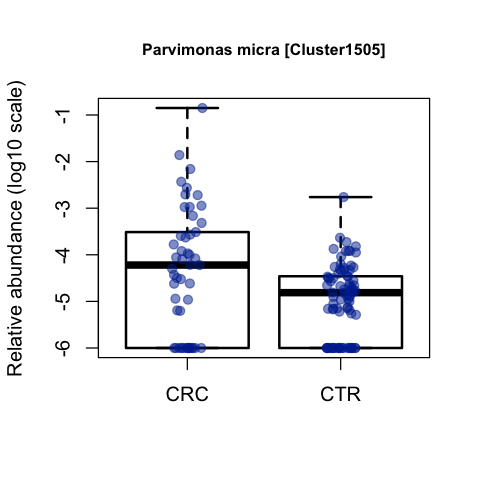

In [10]:
for (i in sign.idx) {
    sign.taxon.df <- data.frame(filt.rel.ab = log10(filt.rel.ab[i,] + 1E-6), 
                                groups = as.factor(meta$Group))
    boxplot(filt.rel.ab ~ groups, data = sign.taxon.df,
            ylab = 'Relative abundance (log10 scale)', 
            main = rownames(filt.rel.ab)[i], cex.main = 0.8,
            lwd = 2, names = as.character(levels(sign.taxon.df$groups)))
    stripchart(filt.rel.ab ~ groups, data = sign.taxon.df,
               method = "jitter", vertical = TRUE, 
               add = TRUE, pch = 20, cex = 1.5, col = '#0030A080')
}


##### Caveat
When there are very pronounced changes in community composition, the compositionality of the (relative) microbial abundance data may cause spurious associations, in particular if one or some of the most abundant taxa are altered in abundance.

### Visualization of differential taxa as heatmap
here we use R's basic image function, but ```heatmap.2``` also offers very nice functionality.

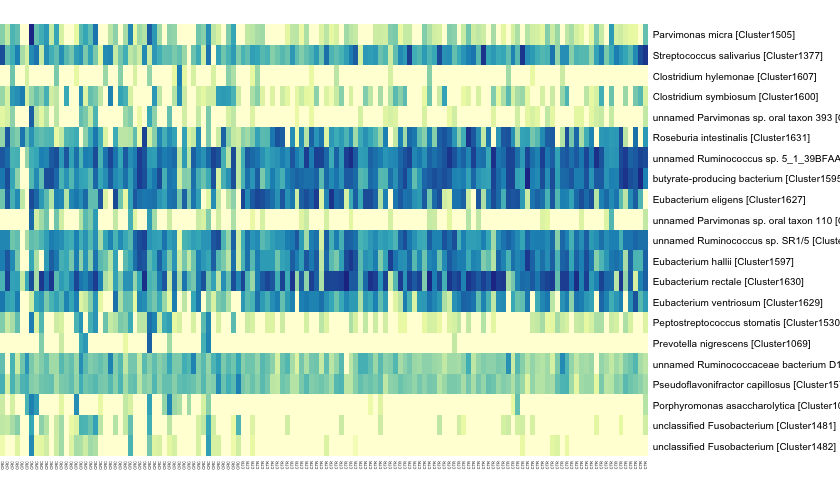

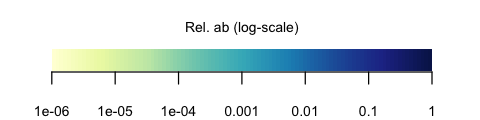

In [11]:
col.scheme <- colorRampPalette(brewer.pal(9,'YlGnBu'))(100)

img.data <- t(log10(filt.rel.ab[sign.idx,] + 1E-6))

# set figure dimensions
options(repr.plot.width = 7, repr.plot.height = 4)
par(mar = c(1,0,1,8))

zlim <- c(-6, 0)

image(img.data, xaxt = 'n', yaxt = 'n', xlab = '', ylab = '', bty = 'n',
      zlim = zlim, col = col.scheme)

for (t in 1:length(sign.idx)) {
    mtext(rownames(filt.rel.ab)[sign.idx[t]], side = 4, line = 0.2, cex = 0.5, las = 2,
          at = (t-1) / (length(sign.idx)-1))
}

for (s in 1:ncol(filt.rel.ab)) {
    mtext(meta$Group[s], side = 1, line = 0.2, cex = 0.2, las = 2,
          at = (s-1) / (ncol(filt.rel.ab)-1))
}


# set figure dimensions for color key
options(repr.plot.width = 4, repr.plot.height = 1)
par(mar = c(2,2,2,2))

barplot(as.matrix(rep(1,100)), col = col.scheme, horiz = TRUE, border = 0, ylab = '', 
        axes = FALSE)
key.ticks <- seq(zlim[1], zlim[2], length.out=7)
axis(side = 1, at = seq(0, 100, length.out=7), labels = 10^key.ticks, cex.axis = 0.7)
mtext('Rel. ab (log-scale)', side = 3, line = 0.5, at = 50, cex = 0.7, adj = 0.5)


## Correlation analysis

To assess the correlation between microbial taxa and an external factor with continous values (in the below we will use host age as an example), Spearman correlation is a good choice as it is robust to the complex distribution of microbiome abundance data, an alternative can be Pearson correlation on suitably transformed abundance data (e.g. log-transformed relative abundances).

In [12]:
# correlate taxa with age
corr.p.values <- rep(1, nrow(filt.rel.ab))

for (t in 1:nrow(filt.rel.ab)) {
    corr.p.values[t] <- cor.test(filt.rel.ab[t,], meta$Age, 
                                 method = 'spearman', exact=FALSE)$p.value}
corr.p.values <- p.adjust(corr.p.values, method = 'fdr')
sign.idx <- which(corr.p.values < 0.1)
for (i in sign.idx) {
    cat(rownames(filt.rel.ab)[i], ': ', format(corr.p.values[i]), '\n', sep='')
    plot(meta$Age, log10(filt.rel.ab[i,] + 1E-6), pch = 16, col = 'blue',
         main = rownames(filt.rel.ab)[i], cex.main = 0.8,
         xlab = 'Host Age', ylab = 'Relative abundance (log10-scale)')
    mtext(paste('rho =', format(cor(filt.rel.ab[i,], meta$Age, method = 'spearman'),
                                digits=3)))
}

##### Caveat
Although the correlations above are statistically significant, they may not be very robust, in particular when taxa are involved that are not detectable in most of the communities. The compositional nature of microbiome data can moreover cause spurious correlations, see [Friedman & Alm](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002687), [Weiss et al., 2016](http://www.nature.com/ismej/journal/v10/n7/full/ismej2015235a.html).

### Shameless plug
Many of the tools we worked with in this notebook and additional machine learning approaches suitable for the analysis of microbiome data are implemented in the siamcat toolbox, which can be found at [siamcat.embl.de](siamcat.embl.de).

## Exercises

##### Task 1
Explore basic characteristics of your data set using functions ```head```, ```dim``` and ```table``` (e.g. ```table(meta$Group)```; assess distribution of library size (using ```hist```) and find a suitable minimal library size for rarefying.

##### Task 2
Visualize other dissimilarity matrices using the ```image``` function and visually explore whether samples cluster by group using PCoA.

##### Task 3
Choose another dissimilarity measure from the vegan package and include it in the list (```diss.list```).

##### Task 4
Run kNN classification on the other dissimilarity measures and compare the results. Try to assess whether a particular one works best for the data you're looking at.

__Optional:__ Modify the kNN classifier to operate on the first two principal coordinates to assess separation in the ordination plot (hint: use Euclidean distance on the projection).

##### Task 5
Explore how the result of statistical testing changes if abundance filtering is omitted. To understand the difference, it can be instructive to isolate the effect of multiple testing correction (```p.adjust```).

##### Task 6
For a deeper understanding of whether nonparametric statistics should be preferred over parametric ones, it is instructive to visually explore microbial abundance features. Based on these empirical distributions, ask yourself whether the application of parametric methods, such as Student's T-test assuming Gaussian data, can be justified.

Hint: _Prevotella copri_ (the 32th species in the tables loaded above) is an interesting example; try plotting a histogram of ```log10(rel.ab[32,] + 1E-6)```

__Optional:__ Use the Shapiro Wilks goodness-of-fit test to assess whether microbial abundance data follows a Gaussian distribution (you can also apply it to log-transformed relative abundance, or zero-filtered log-trasnformed relative abundance)

##### Task 7
Replace the data sets above by your own data (or any other data that is publicly available) and recapitulate the analyses on that.

Hint: make sure you have metadata in an appropriate format with a column ```Group``` that is a two-level factor.

#####  Task 8
Explore the effects of different abundance preprocessing techniques (relative abundance versus rarefied counts, both with and without log transformation).

##### Task 9a
Try to combine two data sets to perform cross-study comparisons (meta-analysis). You can e.g. use ```cbind``` and ```rbind``` on tow of teh data sets above. Introduce an additonal column in the ```meta``` data frame that keeps track of the original study.

##### Task 9b
Use PCoA to explore how strong batch and study (protocol) effects are relatve to each other.

##### Task 9c
Perform univariate Wilcoxon tests on the combined data set. To account for study effects as potential confounders, the ```coin``` package offers permutation based tests that allow for blocking (by study). You can substitute these in the code above and compare the results to a naive test on the combined data.

Hint: the syntax is a bit different, the below should help
```
pvalue(wilcoxon_test(meta$Group ~ filt.rel.ab[t,] | as.factor(meta$Study)))
```
